# 基本信息
1. 实验名称：实验3 网络优化实验
2. 姓名：
3. 学号：
4. 日期：2022年11月11日

> 本次实验数据集使用的是Minst

# 手动实现dropout


In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
train_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST/", train=True, transform= transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST", train=False, transform= transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=False)

In [ ]:
class net_manual_dropout:
    def __init__(self):
        input = 784
        output = 10

        self.hidden1 = 512
        self.hidden2 = 256

        self.net1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input, self.hidden1),
            nn.ReLU()
        )
    #     considering func dropout has not extended class nn.Module, so set three sub-net
        self.net2 = nn.Sequential(
            nn.Linear(self.hidden1, self.hidden2),
            nn.ReLU()
        )
        self.net3 = nn.Sequential(
            nn.Linear(self.hidden2, output)
        )

        for i in [self.net1, self.net2, self.net3]:
            i.apply(self.init_weights)

        self.params = [
            {'params': self.net1.parameters()},
            {'params': self.net2.parameters()},
            {'params': self.net3.parameters()}
        ]

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    def dropout(self, X, drop_prob):
        X = X.float()
        assert 0<= drop_prob <= 1
        keep_prob = 1-drop_prob
        if keep_prob == 0:
            return torch.zeros_like(X)
        mask = (torch.rand(X.shape) < keep_prob).float()
        return mask * X / keep_prob


    def forward(self, X, drop1=0.0, drop2=0.0):
        result1 = self.net1(X)
        result2 = self.dropout(result1, drop1)
        result3 = self.net2(result2)
        result4 = self.dropout(result3, drop2)
        result5 = self.net3(result4)
        return result5
    def predict(self, X):
        result = self.forward(X, 0, 0)
        return torch.nn.Softmax(dim=1)(result)

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        acc_sum = (net.predict(X).argmax(dim=1) == y).float().sum().item()
        n += y.shape[0]
    return acc_sum / n

In [12]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)

def eval_acc(net, data_iter):
    result = []
    with torch.no_grad():
        for X, y in data_iter:
            result.append(accuracy(net.forward(X), y))
    return np.array(result).mean()

In [ ]:
def train_manual_dropout(net, loss, train_loader, test_loader, epochs, batch_size, optimizer,name_net, dropout=[0.0,0.0]):
    train_loss_ls = []
    # test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X, dropout[0], dropout[1])
        l = loss(y_hat, y)
        
        acc += accuracy(y_hat, y)
       
        # if type(optimizer) == torch.optim.Optimizer:
        optimizer.zero_grad()
        l.mean().backward()   
        optimizer.step()
        # else:
        #   l.sum().backward()
        #   optimizer([W, b], lr, batch_size)
        l_sum += l.sum()/ y.shape[0]
        num+=1
        
        # need to be summed
    
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num) 
        acc_test_ls.append(test_acc) # have gain mean
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    # plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

epochs 1 train_loss 2.0578 train_acc 0.2717 test_acc 0.7123
epochs 2 train_loss 0.7316 train_acc 0.7689 test_acc 0.8710
epochs 3 train_loss 0.4633 train_acc 0.8660 test_acc 0.8951
epochs 4 train_loss 0.3688 train_acc 0.8930 test_acc 0.9219
epochs 5 train_loss 0.3086 train_acc 0.9119 test_acc 0.9292
epochs 6 train_loss 0.2617 train_acc 0.9247 test_acc 0.9438
epochs 7 train_loss 0.2253 train_acc 0.9360 test_acc 0.9498
epochs 8 train_loss 0.1963 train_acc 0.9438 test_acc 0.9553
epochs 9 train_loss 0.1775 train_acc 0.9493 test_acc 0.9575
epochs 10 train_loss 0.1595 train_acc 0.9536 test_acc 0.9624
epochs 11 train_loss 0.1452 train_acc 0.9590 test_acc 0.9658
epochs 12 train_loss 0.1352 train_acc 0.9612 test_acc 0.9655
epochs 13 train_loss 0.1273 train_acc 0.9629 test_acc 0.9681
epochs 14 train_loss 0.1168 train_acc 0.9663 test_acc 0.9701
epochs 15 train_loss 0.1101 train_acc 0.9685 test_acc 0.9728
epochs 16 train_loss 0.1034 train_acc 0.9700 test_acc 0.9717
epochs 17 train_loss 0.0981 train

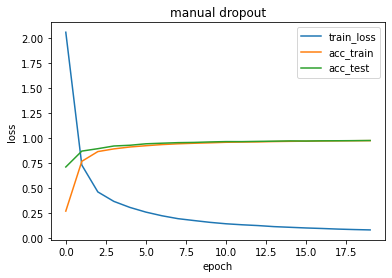

In [ ]:
epochs = 20
lr = 0.1
batch_size = 1024
loss = nn.CrossEntropyLoss(reduction="none")
dropout = [0.2, 0.5]
net = net_manual_dropout()

optimizer = torch.optim.SGD(net.params, lr)
train_manual_dropout(net, loss, train_loader, test_loader, epochs, 256, optimizer, "manual dropout", dropout)

不进行dropout

epochs 1 train_loss 0.0780 train_acc 0.9771 test_acc 0.9764
epochs 2 train_loss 0.0744 train_acc 0.9783 test_acc 0.9771
epochs 3 train_loss 0.0719 train_acc 0.9790 test_acc 0.9797
epochs 4 train_loss 0.0689 train_acc 0.9801 test_acc 0.9775
epochs 5 train_loss 0.0664 train_acc 0.9812 test_acc 0.9779
epochs 6 train_loss 0.0641 train_acc 0.9816 test_acc 0.9787
epochs 7 train_loss 0.0599 train_acc 0.9826 test_acc 0.9805
epochs 8 train_loss 0.0586 train_acc 0.9831 test_acc 0.9776
epochs 9 train_loss 0.0556 train_acc 0.9839 test_acc 0.9793
epochs 10 train_loss 0.0533 train_acc 0.9850 test_acc 0.9796
epochs 11 train_loss 0.0510 train_acc 0.9852 test_acc 0.9805
epochs 12 train_loss 0.0498 train_acc 0.9851 test_acc 0.9806
epochs 13 train_loss 0.0476 train_acc 0.9861 test_acc 0.9809
epochs 14 train_loss 0.0464 train_acc 0.9864 test_acc 0.9800
epochs 15 train_loss 0.0435 train_acc 0.9873 test_acc 0.9820
epochs 16 train_loss 0.0421 train_acc 0.9880 test_acc 0.9814
epochs 17 train_loss 0.0412 train

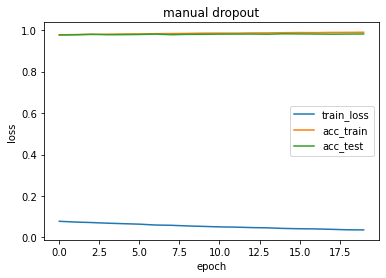

In [ ]:
epochs = 20
lr = 0.1
batch_size = 1024
loss = nn.CrossEntropyLoss(reduction="none")
# dropout = [0.2, 0.5]
net1 = net_manual_dropout()

optimizer = torch.optim.SGD(net.params, lr)
train_manual_dropout(net, loss, train_loader, test_loader, epochs, 256, optimizer, "manual dropout", dropout)

# torch.nn 实现dropout

In [ ]:
class net_dropout_nn:
  def __init__(self, prob1, prob2):
    self.net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Dropout(prob1),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(prob2),
        nn.Linear(256, 10)
    )
    for param in self.net.parameters():
        nn.init.normal_(param, std=0.01)
    self.params = self.net.parameters()
  def forward(self, X):
    return self.net(X)

In [ ]:
def train_nn_dropout(net, loss, train_loader, test_loader, epochs, batch_size, optimizer,name_net, dropout=[0.0,0.0]):
    train_loss_ls = []
    # test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        
        acc += accuracy(y_hat, y)
       
        # if type(optimizer) == torch.optim.Optimizer:
        optimizer.zero_grad()
        l.mean().backward()   
        optimizer.step()
        # else:
        #   l.sum().backward()
        #   optimizer([W, b], lr, batch_size)
        l_sum += l.sum()/ y.shape[0]
        num+=1
        
        # need to be summed
    
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num) 
        acc_test_ls.append(test_acc) # have gain mean
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    # plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

epochs 1 train_loss 1.9995 train_acc 0.3607 test_acc 0.6672
epochs 2 train_loss 0.6886 train_acc 0.7855 test_acc 0.8491
epochs 3 train_loss 0.4424 train_acc 0.8722 test_acc 0.8890
epochs 4 train_loss 0.3573 train_acc 0.8973 test_acc 0.9052
epochs 5 train_loss 0.3000 train_acc 0.9141 test_acc 0.9255
epochs 6 train_loss 0.2559 train_acc 0.9270 test_acc 0.9321
epochs 7 train_loss 0.2238 train_acc 0.9363 test_acc 0.9389
epochs 8 train_loss 0.1978 train_acc 0.9425 test_acc 0.9470
epochs 9 train_loss 0.1749 train_acc 0.9499 test_acc 0.9501
epochs 10 train_loss 0.1604 train_acc 0.9539 test_acc 0.9550
epochs 11 train_loss 0.1471 train_acc 0.9576 test_acc 0.9558
epochs 12 train_loss 0.1364 train_acc 0.9610 test_acc 0.9576
epochs 13 train_loss 0.1254 train_acc 0.9643 test_acc 0.9590
epochs 14 train_loss 0.1160 train_acc 0.9664 test_acc 0.9604
epochs 15 train_loss 0.1081 train_acc 0.9694 test_acc 0.9667
epochs 16 train_loss 0.1027 train_acc 0.9700 test_acc 0.9687
epochs 17 train_loss 0.0976 train

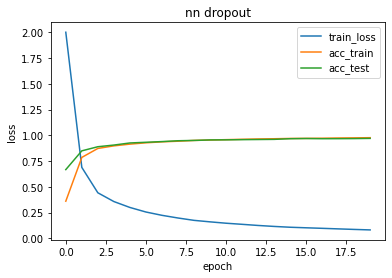

In [ ]:
epochs = 20
lr = 0.1
batch_size = 1024
loss = nn.CrossEntropyLoss(reduction="none")
dropout = [0.2, 0.5]
net = net_dropout_nn(0.2, 0.5)

optimizer = torch.optim.SGD(net.params, lr)
train_nn_dropout(net, loss, train_loader, test_loader, epochs, 256, optimizer, "nn dropout", dropout)

# 手动实现 L2 正则化

In [21]:
class net_manual_L2:
    def __init__(self):
        input = 784
        output = 10

        self.hidden1 = 512
        self.hidden2 = 256

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input, self.hidden1),
            nn.ReLU(),
            nn.Linear(self.hidden1, self.hidden2),
            nn.ReLU(),
            nn.Linear(self.hidden2, output)
        )
        self.net.apply(self.init_weights)
        self.params = self.net.parameters()

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    def forward(self, X):
        return self.net(X)

In [26]:
def l2_pennalty(net):
    pennalty = torch.zeros(1)
    for i in net.net:
        if type(i) == nn.Linear:
          pennalty += (i.weight ** 2).mean() / 2 
    return pennalty

In [14]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)

def eval_acc(net, data_iter):
    result = []
    with torch.no_grad():
        for X, y in data_iter:
            result.append(accuracy(net.forward(X), y))
    return np.array(result).mean()

In [18]:
def train_manual_L2(net, loss, train_loader, test_loader, epochs, batch_size, optimizer,name_net, lambd):
    train_loss_ls = []
    # test_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X)
        l = loss(y_hat, y) + lambd *l2_pennalty(net)
        
        acc += accuracy(y_hat, y)
       
        # if type(optimizer) == torch.optim.Optimizer:
        optimizer.zero_grad()
        l.backward()   
        optimizer.step()
        # else:
        #   l.sum().backward()
        #   optimizer([W, b], lr, batch_size)
        l_sum += l/ y.shape[0]
        num+=1
        
        # need to be summed
    
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num) 
        acc_test_ls.append(test_acc) # have gain mean
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    # plt.plot(test_loss_ls, label='test_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

epochs 1 train_loss 0.0078 train_acc 0.2962 test_acc 0.6517
epochs 2 train_loss 0.0024 train_acc 0.8076 test_acc 0.8708
epochs 3 train_loss 0.0015 train_acc 0.8892 test_acc 0.8987
epochs 4 train_loss 0.0013 train_acc 0.9088 test_acc 0.9175
epochs 5 train_loss 0.0011 train_acc 0.9213 test_acc 0.9283


/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.7/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


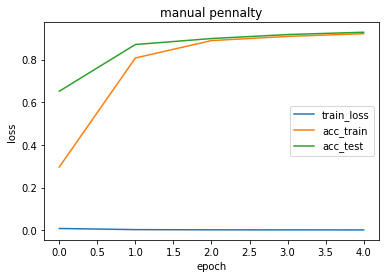

In [27]:
epochs = 5
lr = 0.1
batch_size = 1024
loss = nn.CrossEntropyLoss()
dropout = [0.2, 0.5]
net = net_manual_L2()

optimizer = torch.optim.SGD(net.params, lr)

train_manual_L2(net, loss, train_loader, test_loader, epochs, 256, optimizer, "manual pennalty", 0.1)

发现一开始crossentroyloss 用了不求和的版本，这样把每个权重都加上了惩罚，且lambda和实验指导中一样取了3，,这样模型根本不能拟合，即惩罚力度过大。同时，通过自行实验和网络博客查看，发现惩罚取平均而不是简单加和，效果更好。


epochs 1 train_loss 0.0079 train_acc 0.3087 test_acc 0.7011
epochs 2 train_loss 0.0024 train_acc 0.8122 test_acc 0.8581
epochs 3 train_loss 0.0015 train_acc 0.8877 test_acc 0.8994
epochs 4 train_loss 0.0013 train_acc 0.9085 test_acc 0.9175
epochs 5 train_loss 0.0011 train_acc 0.9226 test_acc 0.9257


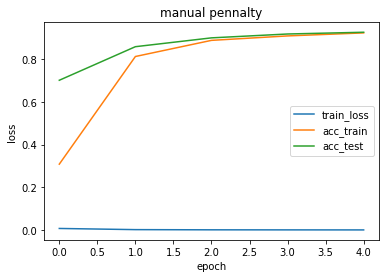

In [28]:
epochs = 5
lr = 0.1
batch_size = 1024
loss = nn.CrossEntropyLoss()

net = net_manual_L2()

optimizer = torch.optim.SGD(net.params, lr)

train_manual_L2(net, loss, train_loader, test_loader, epochs, 256, optimizer, "manual pennalty", 0)

通过对比发现，加入L2正则化的效果会在千分位上有所改善（似乎没什么大用处，但是轮数更多的实验跑不动了，哭泣）

# torch.nn实现L2正则化

In [39]:
class net_nn_L2:
    def __init__(self):
        input = 784
        output = 10

        self.hidden1 = 512
        self.hidden2 = 256

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input, self.hidden1),
            nn.ReLU(),
            nn.Linear(self.hidden1, self.hidden2),
            nn.ReLU(),
            nn.Linear(self.hidden2, output)
        )
        self.net.apply(self.init_weights)
        self.params = self.net.parameters()

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    def forward(self, X):
        return self.net(X)

In [33]:
def train_nn_L2(net, loss, train_loader, test_loader, epochs, batch_size, optimizer,name_net, lambd):
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X)
        # l = loss(y_hat, y) + lambd *l2_pennalty(net)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        optimizer.zero_grad()
        l.backward()   
        optimizer.step()
        l_sum += l/ y.shape[0]
        num+=1    
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num) 
        acc_test_ls.append(test_acc) 
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

epochs 1 train_loss 0.0082 train_acc 0.2668 test_acc 0.6906
epochs 2 train_loss 0.0028 train_acc 0.7835 test_acc 0.8373
epochs 3 train_loss 0.0018 train_acc 0.8688 test_acc 0.8785
epochs 4 train_loss 0.0015 train_acc 0.8913 test_acc 0.8886
epochs 5 train_loss 0.0014 train_acc 0.9025 test_acc 0.9093


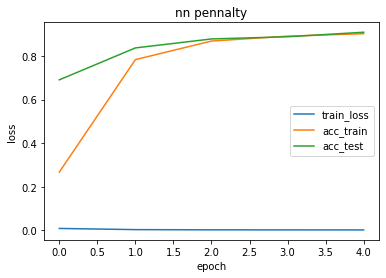

In [42]:
epochs = 5
lr = 0.1
loss = nn.CrossEntropyLoss()
net = net_nn_L2()

optimizer = torch.optim.SGD(net.params, lr, weight_decay=0.01)
train_nn_L2(net, loss, train_loader, test_loader, epochs, 256, optimizer, "nn pennalty", 0)

实验指导书中，将weight和bias分开两个优化器的做法太过高级，在自定义网络下，没想到简单的处理方法，这里直接简单处理了。

In [ ]:
epochs = 30
lr = 0.1
loss = nn.CrossEntropyLoss()
net = net_nn_L2()

optimizer = torch.optim.SGD(net.params, lr, weight_decay=0.0)
train_nn_L2(net, loss, train_loader, test_loader, epochs, 256, optimizer, "nn pennalty", 0)

In [ ]:
epochs = 30
lr = 0.1
loss = nn.CrossEntropyLoss()
net = net_nn_L2()

optimizer = torch.optim.SGD(net.params, lr, weight_decay=0.01)
train_nn_L2(net, loss, train_loader, test_loader, epochs, 256, optimizer, "nn pennalty", 0)

L2正则化的效果还是有的，不过在这个网络上过拟合现象不是很严重，效果不是很大

# 手动实现momentum、rmsprop、adam

## 手动momentum

In [ ]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)


def eval_acc(net, data_iter):
    result = []
    with torch.no_grad():
        for X, y in data_iter:
            result.append(accuracy(net.forward(X), y))
    return np.array(result).mean()

In [ ]:
class net_manual_momentum:
    def __init__(self):
        input = 784
        output = 10

        self.hidden1 = 512
        self.hidden2 = 256

        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input, self.hidden1),
            nn.ReLU(),
            nn.Linear(self.hidden1, self.hidden2),
            nn.ReLU(),
            nn.Linear(self.hidden2, output)
        )
        self.net.apply(self.init_weights)
        self.params = self.net.parameters()

    def init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=0.01)

    def forward(self, X):
        return self.net(X)

In [ ]:
net = net_manual_momentum()

In [ ]:
for i in net.net.parameters():
  print(i.shape)

In [ ]:
for i in net.net.parameters():
  print(type(i))

In [ ]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)


def eval_acc(net, data_iter):
    result = []
    with torch.no_grad():
        for X, y in data_iter:
            result.append(accuracy(net.forward(X), y))
    return np.array(result).mean()

def init_momentum_states(net):
    state = []
    for i in net.net.parameters():
      state.append(torch.zeros_like(i))
    return state

def sgd_momentum(params, states:list, lr, momentum):
    for p, v in zip(params, states):
        with torch.no_grad():
            v *= momentum
            v += lr * p.grad.data
            p.data -= v
        p.grad.data.zero_()

In [ ]:
def train_momentum(net, loss, lr, momentum, train_loader, test_loader, epochs, optimizer:sgd_momentum,name_net):
    states = []
    for i in net.params:
        states.append(torch.zeros_like(i.data))

    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        # optimizer.zero_grad()
        l.backward()
        # optimizer.step()

        optimizer(net.net.parameters(), states, lr, momentum)
        l_sum += l/ y.shape[0]
        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
optimizer = sgd_momentum
momentum = 0.9
lr = 0.1
train_momentum(net, loss, lr, momentum, train_loader, test_loader, epochs, optimizer, "manual momentum")

## torch.nn 实现momentum

In [ ]:
def train_nn_momentum(net, loss,train_loader, test_loader, epochs, optimizer,name_net):
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        optimizer.zero_grad()
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        # optimizer.zero_grad()
        l.backward()
        # optimizer.step()

        # optimizer(net.params, states, lr, momentum)
        optimizer.step()
        l_sum += l/ y.shape[0]

        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)


def eval_acc(net, data_iter):
    result = []
    with torch.no_grad():
        for X, y in data_iter:
            result.append(accuracy(net.forward(X), y))
    return np.array(result).mean()

In [ ]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.1
momentum = 0.1
optimizer = torch.optim.SGD(net.params, lr, momentum=momentum)

train_nn_momentum(net, loss, train_loader, test_loader, epochs, optimizer, "nn momentum")

## 手动rmsprop

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

In [ ]:
train_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST/", train=True, transform= transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST", train=False, transform= transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=False)

In [ ]:
def init_rmsprop_states(net):
    states = []
    if isinstance(net, nn.Linear):
        for i in net.parameters():
            print(i.shape)
            states.append(torch.zeros(i.shape))
    else:
        for i in net.net.parameters():
            states.append(torch.zeros(i.shape))
    return states

In [ ]:
def rmsprop(params, states, lr, gamma):
    gamma, eps = gamma, 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            # s[:] = gamma * s + (1-gamma) * torch.square(p.grad)
            s *= gamma
            s += (1-gamma) * torch.square(p.grad)
            p -= lr* p.grad / torch.sqrt(s+eps)

        p.grad.data.zero_()

In [ ]:
def train_rmsprop(net, loss, lr, gamma, train_loader, test_loader, epochs, optimizer,name_net):
    states = init_rmsprop_states(net)
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        l.backward()
        optimizer(net.net.parameters(), states, lr, gamma)
        # print(states[0][0][23])
        l_sum += l/ y.shape[0]
        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


In [ ]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = rmsprop
gamma = 0.9
train_rmsprop(net, loss, lr, gamma, train_loader, test_loader, epochs, optimizer, "manual RMSprop")

## torch.nn 实现rmsprop

In [ ]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01
gamma = 0.9
optimizer = torch.optim.RMSprop(net.params, lr=lr, alpha=gamma)

train_nn_momentum(net, loss, train_loader, test_loader, epochs, optimizer, "nn RMSprop")

## 手动Adam

In [ ]:
def init_adagrad_states(net):
    states1 = []
    states2 = []
    if isinstance(net, nn.Linear):
        for i in net.parameters():
            states1.append(torch.zeros_like(i))
            states2.append(torch.zeros_like(i))
    else:
        for i in net.net.parameters():
            states1.append(torch.zeros_like(i))
            states2.append(torch.zeros_like(i))
        return zip(states1, states2)
        # return states1

def adagrad(params, state1, state2, lr, t):
    eps = 1e-6
    beta1, beta2 = 0.9, 0.999
    for p, v, s in zip(params, state1, state2):
        with torch.no_grad():

            # v[:] = momentum * v + p.grad
            v *= beta1
            v += (1-beta1) * p.grad

            s *= beta2
            s += (1-beta2) * torch.square(p.grad)
            v_hat = v / (1-beta1 ** t)
            s_hat = s / (1-beta2 ** t)

            p -= lr* v_hat / torch.sqrt(s_hat + eps)
        p.grad.data.zero_()

In [ ]:
def train_adam(net:net_manual_momentum, loss, lr, train_loader, test_loader, epochs, optimizer,name_net):
    state1 = [torch.zeros_like(i) for i in net.net.parameters()]
    state2 = [torch.zeros_like(i) for i in net.net.parameters()]
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        num+=1
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        l.backward()
        optimizer(net.net.parameters(), state1, state2, lr, num)
        # print(states[0][0][23])
        l_sum += l/ y.shape[0]

      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = adagrad
train_adam(net, loss, lr, train_loader, test_loader, epochs, optimizer, "manual Adam")

## torch.nn 实现Adam


In [ ]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = torch.optim.Adam(net.params, lr = lr)

train_nn_momentum(net, loss, train_loader, test_loader, epochs, optimizer, "nn Adam")

# 实现早停机制

这里选择Adam和L2正则化进行早停实验

In [ ]:
import random
from torch import nn
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

In [ ]:
train_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST/", train=True, transform= transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST", train=False, transform= transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=False)

In [ ]:
# split data set

def train_split(iter, train_size):
    num_example = len(iter)
    indices = list(range(num_example))
    random.shuffle(indices)
    return iter[indices[0:int(num_example*train_size)]], iter[indices[int(num_example*(train_size)):]],

In [ ]:
train_data, val_data = torch.utils.data.random_split(train_datasets, [48000, 12000])

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=256)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=256)

In [ ]:
def train_early_stop(net, loss,train_loader, test_loader, epochs, optimizer,name_net):
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    early_stop = 0
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:

        X.cuda()
        y.cuda()
        optimizer.zero_grad()
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        # optimizer.zero_grad()
        l.backward()
        # optimizer.step()

        # optimizer(net.params, states, lr, momentum)
        optimizer.step()
        l_sum += l/ y.shape[0]

        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        if acc/num > test_acc >= 0.95:
            early_stop +=1
        else:
            early_stop = 0


        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)
        if early_stop>=5:
            print("early stop")
            break
    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [ ]:
epochs = 50
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = torch.optim.Adam(net.params, lr = lr, weight_decay=0.001)

train_early_stop(net, loss, train_loader, val_loader, epochs, optimizer, "early stop")

在train_early_stop中实现早停机制，当发现连续5个epoch，验证集的acc低于训练集的acc，停止训练。同时为了防止训练早期不稳定的问题，加上acc需要大于0.95才开始判定过拟合问题的条件。
我们设置使用adam和l2正则化一起训练。从实验结果看来，比较好的实现了早停的机制。

In [ ]:
print(eval_acc(net, test_loader))

最后将早停的模型在测试集上进行acc计算。可以看出，我们的模型效果，泛化性能比较好，测试集上的acc还比验证集的搞1个百分点。

epochs 1 train_loss 0.0027 train_acc 0.7633 test_acc 0.9501
epochs 2 train_loss 0.0005 train_acc 0.9575 test_acc 0.9661
epochs 3 train_loss 0.0003 train_acc 0.9745 test_acc 0.9752
epochs 4 train_loss 0.0002 train_acc 0.9815 test_acc 0.9783
epochs 5 train_loss 0.0002 train_acc 0.9858 test_acc 0.9769


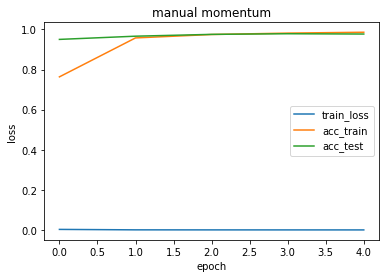

In [7]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
optimizer = sgd_momentum
momentum = 0.9
lr = 0.1
train_momentum(net, loss, lr, momentum, train_loader, test_loader, epochs, optimizer, "manual momentum")

## torch.nn 实现momentum

In [13]:
def train_nn_momentum(net, loss,train_loader, test_loader, epochs, optimizer,name_net):
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        optimizer.zero_grad()
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        # optimizer.zero_grad()
        l.backward()
        # optimizer.step()

        # optimizer(net.params, states, lr, momentum)
        optimizer.step()
        l_sum += l/ y.shape[0]

        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

In [11]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    result = y_hat.type(y.dtype) == y
    # op== is very sensitive with data type, so call tensor.type() to stay the same with y
    return float(result.type(y.dtype).sum())/len(y)


def eval_acc(net, data_iter):
    result = []
    with torch.no_grad():
        for X, y in data_iter:
            result.append(accuracy(net.forward(X), y))
    return np.array(result).mean()

epochs 1 train_loss 0.0076 train_acc 0.3335 test_acc 0.7576
epochs 2 train_loss 0.0021 train_acc 0.8439 test_acc 0.8841
epochs 3 train_loss 0.0014 train_acc 0.8945 test_acc 0.8937
epochs 4 train_loss 0.0012 train_acc 0.9133 test_acc 0.9184
epochs 5 train_loss 0.0010 train_acc 0.9272 test_acc 0.9338


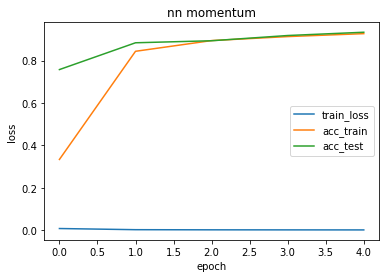

In [13]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.1
momentum = 0.1
optimizer = torch.optim.SGD(net.params, lr, momentum=momentum)

train_nn_momentum(net, loss, train_loader, test_loader, epochs, optimizer, "nn momentum")

## 手动rmsprop

In [16]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

In [17]:
train_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST/", train=True, transform= transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST", train=False, transform= transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=False)

In [8]:
def init_rmsprop_states(net):
    states = []
    if isinstance(net, nn.Linear):
        for i in net.parameters():
            print(i.shape)
            states.append(torch.zeros(i.shape))
    else:
        for i in net.net.parameters():
            states.append(torch.zeros(i.shape))
    return states

In [9]:
def rmsprop(params, states, lr, gamma):
    gamma, eps = gamma, 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            # s[:] = gamma * s + (1-gamma) * torch.square(p.grad)
            s *= gamma
            s += (1-gamma) * torch.square(p.grad)
            p -= lr* p.grad / torch.sqrt(s+eps)

        p.grad.data.zero_()

In [10]:
def train_rmsprop(net, loss, lr, gamma, train_loader, test_loader, epochs, optimizer,name_net):
    states = init_rmsprop_states(net)
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        l.backward()
        optimizer(net.net.parameters(), states, lr, gamma)
        # print(states[0][0][23])
        l_sum += l/ y.shape[0]
        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()


epochs 1 train_loss 0.0021 train_acc 0.8200 test_acc 0.9383
epochs 2 train_loss 0.0006 train_acc 0.9554 test_acc 0.9594
epochs 3 train_loss 0.0004 train_acc 0.9671 test_acc 0.9578
epochs 4 train_loss 0.0004 train_acc 0.9726 test_acc 0.9666
epochs 5 train_loss 0.0003 train_acc 0.9758 test_acc 0.9604


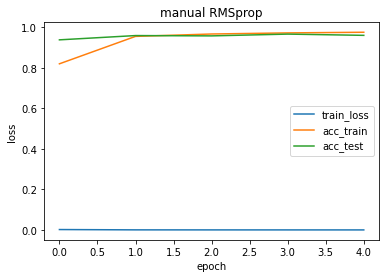

In [11]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = rmsprop
gamma = 0.9
train_rmsprop(net, loss, lr, gamma, train_loader, test_loader, epochs, optimizer, "manual RMSprop")

## torch.nn 实现rmsprop

epochs 1 train_loss 0.0020 train_acc 0.8721 test_acc 0.9493
epochs 2 train_loss 0.0006 train_acc 0.9583 test_acc 0.9479
epochs 3 train_loss 0.0005 train_acc 0.9677 test_acc 0.9505
epochs 4 train_loss 0.0004 train_acc 0.9731 test_acc 0.9614
epochs 5 train_loss 0.0004 train_acc 0.9750 test_acc 0.9599


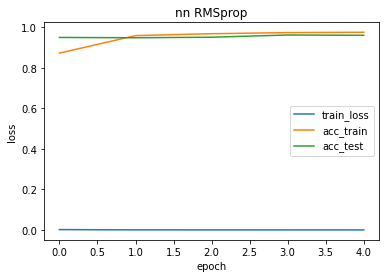

In [199]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01
gamma = 0.9
optimizer = torch.optim.RMSprop(net.params, lr=lr, alpha=gamma)

train_nn_momentum(net, loss, train_loader, test_loader, epochs, optimizer, "nn RMSprop")

## 手动Adam

In [22]:
def init_adagrad_states(net):
    states1 = []
    states2 = []
    if isinstance(net, nn.Linear):
        for i in net.parameters():
            states1.append(torch.zeros_like(i))
            states2.append(torch.zeros_like(i))
    else:
        for i in net.net.parameters():
            states1.append(torch.zeros_like(i))
            states2.append(torch.zeros_like(i))
        return zip(states1, states2)
        # return states1

def adagrad(params, state1, state2, lr, t):
    eps = 1e-6
    beta1, beta2 = 0.9, 0.999
    for p, v, s in zip(params, state1, state2):
        with torch.no_grad():

            # v[:] = momentum * v + p.grad
            v *= beta1
            v += (1-beta1) * p.grad

            s *= beta2
            s += (1-beta2) * torch.square(p.grad)
            v_hat = v / (1-beta1 ** t)
            s_hat = s / (1-beta2 ** t)

            p -= lr* v_hat / torch.sqrt(s_hat + eps)
        p.grad.data.zero_()

In [21]:
def train_adam(net:net_manual_momentum, loss, lr, train_loader, test_loader, epochs, optimizer,name_net):
    state1 = [torch.zeros_like(i) for i in net.net.parameters()]
    state2 = [torch.zeros_like(i) for i in net.net.parameters()]
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:
        num+=1
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        l.backward()
        optimizer(net.net.parameters(), state1, state2, lr, num)
        # print(states[0][0][23])
        l_sum += l/ y.shape[0]

      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)

    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

epochs 1 train_loss 0.0012 train_acc 0.9022 test_acc 0.9658
epochs 2 train_loss 0.0003 train_acc 0.9730 test_acc 0.9669
epochs 3 train_loss 0.0002 train_acc 0.9821 test_acc 0.9739
epochs 4 train_loss 0.0002 train_acc 0.9868 test_acc 0.9811
epochs 5 train_loss 0.0001 train_acc 0.9897 test_acc 0.9801


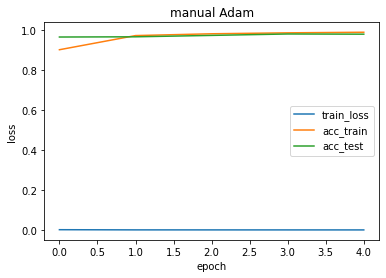

In [23]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = adagrad
train_adam(net, loss, lr, train_loader, test_loader, epochs, optimizer, "manual Adam")

## torch.nn 实现Adam


epochs 1 train_loss 0.0010 train_acc 0.9198 test_acc 0.9617
epochs 2 train_loss 0.0004 train_acc 0.9664 test_acc 0.9721
epochs 3 train_loss 0.0003 train_acc 0.9750 test_acc 0.9738
epochs 4 train_loss 0.0003 train_acc 0.9781 test_acc 0.9597
epochs 5 train_loss 0.0003 train_acc 0.9806 test_acc 0.9758


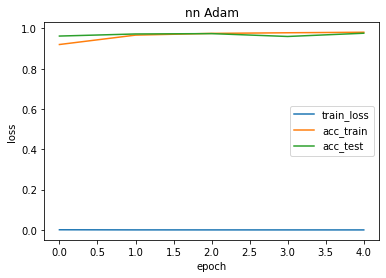

In [286]:
epochs = 5
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = torch.optim.Adam(net.params, lr = lr)

train_nn_momentum(net, loss, train_loader, test_loader, epochs, optimizer, "nn Adam")

# 实现早停机制

这里选择Adam和L2正则化进行早停实验

In [5]:
import random
from torch import nn
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np

In [19]:
train_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST/", train=True, transform= transforms.ToTensor(), download=True)
test_datasets = torchvision.datasets.MNIST(root=f"../Datasets/MNIST", train=False, transform= transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_datasets, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_datasets, batch_size=256, shuffle=False)

In [7]:
# split data set

def train_split(iter, train_size):
    num_example = len(iter)
    indices = list(range(num_example))
    random.shuffle(indices)
    return iter[indices[0:int(num_example*train_size)]], iter[indices[int(num_example*(train_size)):]],

In [20]:
train_data, val_data = torch.utils.data.random_split(train_datasets, [48000, 12000])

In [21]:
train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=256)
val_loader = torch.utils.data.DataLoader(val_data, shuffle=True, batch_size=256)

In [46]:
def train_early_stop(net, loss,train_loader, test_loader, epochs, optimizer,name_net):
    train_loss_ls = []
    acc_test_ls = []
    acc_train_ls = []
    early_stop = 0
    for epoch in range(epochs):
      l_sum = 0.0
      num = 0
      acc =0.0
      for X, y in train_loader:

        X.cuda()
        y.cuda()
        optimizer.zero_grad()
        y_hat = net.forward(X)
        l = loss(y_hat, y)
        acc += accuracy(y_hat, y)
        # optimizer.zero_grad()
        l.backward()
        # optimizer.step()

        # optimizer(net.params, states, lr, momentum)
        optimizer.step()
        l_sum += l/ y.shape[0]

        num+=1
      with torch.no_grad():
        train_loss = l_sum/num
        test_acc = eval_acc(net, test_loader)
        train_loss_ls.append(train_loss)
        acc_train_ls.append(acc/num)
        acc_test_ls.append(test_acc)
        if acc/num > test_acc >= 0.95:
            early_stop +=1
        else:
            early_stop = 0


        for i in net.params:
          i.grad.data.zero_()
        print('epochs', "%d" % (epoch + 1), "train_loss", "%.4f" %(l_sum/ num), "train_acc","%.4f"%(acc/num), "test_acc", "%.4f"%test_acc)
        if early_stop>=5:
            print("early stop")
            break
    plt.title(name_net)
    plt.plot(train_loss_ls, label='train_loss')
    plt.plot(acc_train_ls, label='acc_train')
    plt.plot(acc_test_ls, label='acc_test')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

epochs 1 train_loss 0.0012 train_acc 0.9005 test_acc 0.9440
epochs 2 train_loss 0.0007 train_acc 0.9485 test_acc 0.9466
epochs 3 train_loss 0.0006 train_acc 0.9561 test_acc 0.9532
epochs 4 train_loss 0.0006 train_acc 0.9555 test_acc 0.9597
epochs 5 train_loss 0.0005 train_acc 0.9607 test_acc 0.9557
epochs 6 train_loss 0.0005 train_acc 0.9602 test_acc 0.9515
epochs 7 train_loss 0.0005 train_acc 0.9619 test_acc 0.9551
epochs 8 train_loss 0.0005 train_acc 0.9624 test_acc 0.9521
epochs 9 train_loss 0.0005 train_acc 0.9627 test_acc 0.9564
early stop


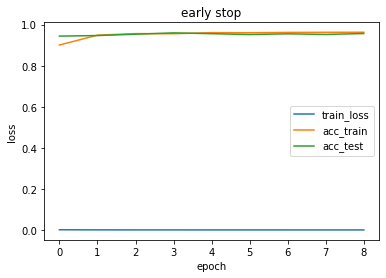

In [48]:
epochs = 50
loss = nn.CrossEntropyLoss()
net = net_manual_momentum()
lr = 0.01

optimizer = torch.optim.Adam(net.params, lr = lr, weight_decay=0.001)

train_early_stop(net, loss, train_loader, val_loader, epochs, optimizer, "early stop")

在train_early_stop中实现早停机制，当发现连续5个epoch，验证集的acc低于训练集的acc，停止训练。同时为了防止训练早期不稳定的问题，加上acc需要大于0.95才开始判定过拟合问题的条件。
我们设置使用adam和l2正则化一起训练。从实验结果看来，比较好的实现了早停的机制。

In [50]:
print(eval_acc(net, test_loader))

0.9619140625


最后将早停的模型在测试集上进行acc计算。可以看出，我们的模型效果，泛化性能比较好，测试集上的acc还比验证集的搞1个百分点。

# 实验心得
1. 这次实验，主要是各个网络优化方法的对比。就实验目的而言，其实目的是达到了的，本人通过自己编写各个优化方法，一次次的调参，切实感受到了不同的方法配合不同的超参数，有不一样的效果。只是最后感觉碍于gpu资源的限制，选择了Minst数据集的缘故——也可能是本人baseline选择的是三层的感知机，本身效果就很好，体现不出调参的效果——调参的效果不是很显著，甚至，最后用上了adam和l2正则化但是acc还达不到使用之前使用SGD的99%。
2. adam手动实现发现loss是nan，判断为除以了0，后来发现是参数t第一个值为零，遂修改。
3. 最开始在net中定义了一个param参数为网络中的子网络的parameters()的引用，这样在没有继承nn.module时可以少一层调用。最后发现参数只会在第一个batch size进行更新，后边都不会再更新了。最后发现，原来net.parameters()返回的是一个generator类型的一次性迭代器。只能被迭代一次，用一次少一次，所以参数只会更新一次。无独有偶，在手动实现adam中，init_states函数中也是返回了一个zip类型的states，这样也是只能迭代一次。